# Compare polynomial fitting with neural network regressor
In this example, a noisy cosine function is fitted by 3 polynomes of different orders, and 3 neural networks with different layers sizes.

***
## Import usefull libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow
print(tensorflow.__version__)

from keras.models import Sequential
from keras.layers import Input, Dense

#import tf_keras as keras
#from tf_keras.models import Sequential
#from tf_keras.layers import Input, Dense

2025-05-09 19:23:16.598482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.1


***
## Polynomial fit

### Define the function we want to interpolate.

In [2]:
def true_fun(x):
    return np.cos(1.5 * np.pi * x)

### Define some parameters. The X_train and y_train sets are used to determine the polynome coefficients and also to train the neural networks. 

In [3]:
# A random seed to reproduce the results
np.random.seed(0)

# The number of points used to fit the function
n_samples = 30

# Noise to be added to the points used to fit the function
noise = 0.1

# The training set: n_samples X points, with the noisy correspoing y  
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * noise
X_train = X
X_train2 = np.expand_dims(X_train, axis=1) # The input to the neural network, an additional dimension is needed
y_train_true = y

# The set of points to verify the fit quality
X_test = np.linspace(0, 1, 100)
X_test2 = np.expand_dims(X_test, axis=1) # The test to the neural network, an additional dimension is needed
y_test_true = true_fun(X_test)

In [4]:
print(X)

[0.0202184  0.07103606 0.0871293  0.11827443 0.14335329 0.38344152
 0.41466194 0.4236548  0.43758721 0.46147936 0.52184832 0.52889492
 0.54488318 0.5488135  0.56804456 0.60276338 0.63992102 0.64589411
 0.71518937 0.77815675 0.78052918 0.79172504 0.79915856 0.83261985
 0.87001215 0.891773   0.92559664 0.94466892 0.96366276 0.97861834]


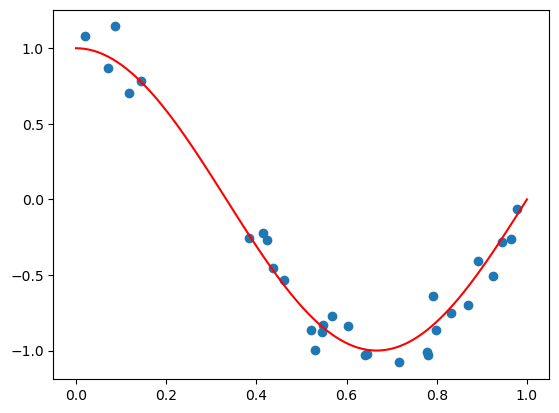

In [5]:
f, ax = plt.subplots()
plt.scatter(X_train2, y_train_true)
plt.plot(X_test, y_test_true, c='r');

### A fit to the data points is done using a polynome of order 3 

$$ y(X) = A + B . X + C . X^2 + D . X^3 $$

In [6]:
degree = 3
z_np3 = np.polyfit(X_train, y_train_true, degree)
p_np3 = np.poly1d(z_np3)

In [7]:
z_np3

array([ 8.202858  , -7.05669992, -2.19617614,  1.16939412])

### The RMS of the fit computed on the training set used to determine the coefficients is computed.

In [8]:
y_train_np3 = p_np3(X_train)
rms_train_np3 = np.sqrt(mean_squared_error(y_train_np3,y_train_true))
print(rms_train_np3)

0.11172558895135497


### The RMS of the fit computed on the test sample (100 points between 0 and 1) is computed.

In [9]:
y_test_np3 = p_np3(X_test)
rms_test_np3 = np.sqrt(mean_squared_error(y_test_np3,y_test_true))

### A plot is done to show the original function, the training sample, the polynomial fit.

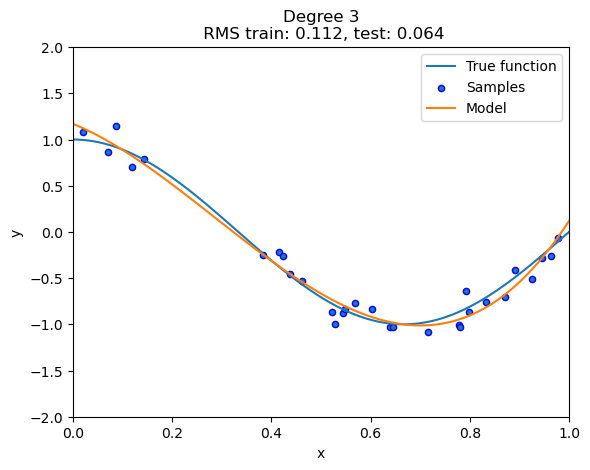

In [10]:
f, ax = plt.subplots()
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
ax.plot(X_test, y_test_np3, label="Model")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}".format(degree,
             rms_train_np3, rms_test_np3));

***
## A Neural Network is used on the same data points. 

### General description of the ANN

An Analogic Neural Network in "only" a linear combination of series of simple "activation" functions, which are very basic function going smoothly from one value for x < 0 to another value for x > 0, for example from -1 to 1 in the case of $tanh(x)$. The coefficients of the combination are called **weigths**, and the constant parameter is called **bias**.

In the following example, 2 neurons are considered. Each neuron apply the activation $atanh$ function to a linear transformation of the previous layer, in this case the $X$ input. The output of each neuron is sent to the next layer, here the final output $y$, which also linearly combine what comes from the hidden layer. Each connection between neurons (synapse) has a **weight** parameter, and each neuron has a **bias** parameter, to define these linear combinations.

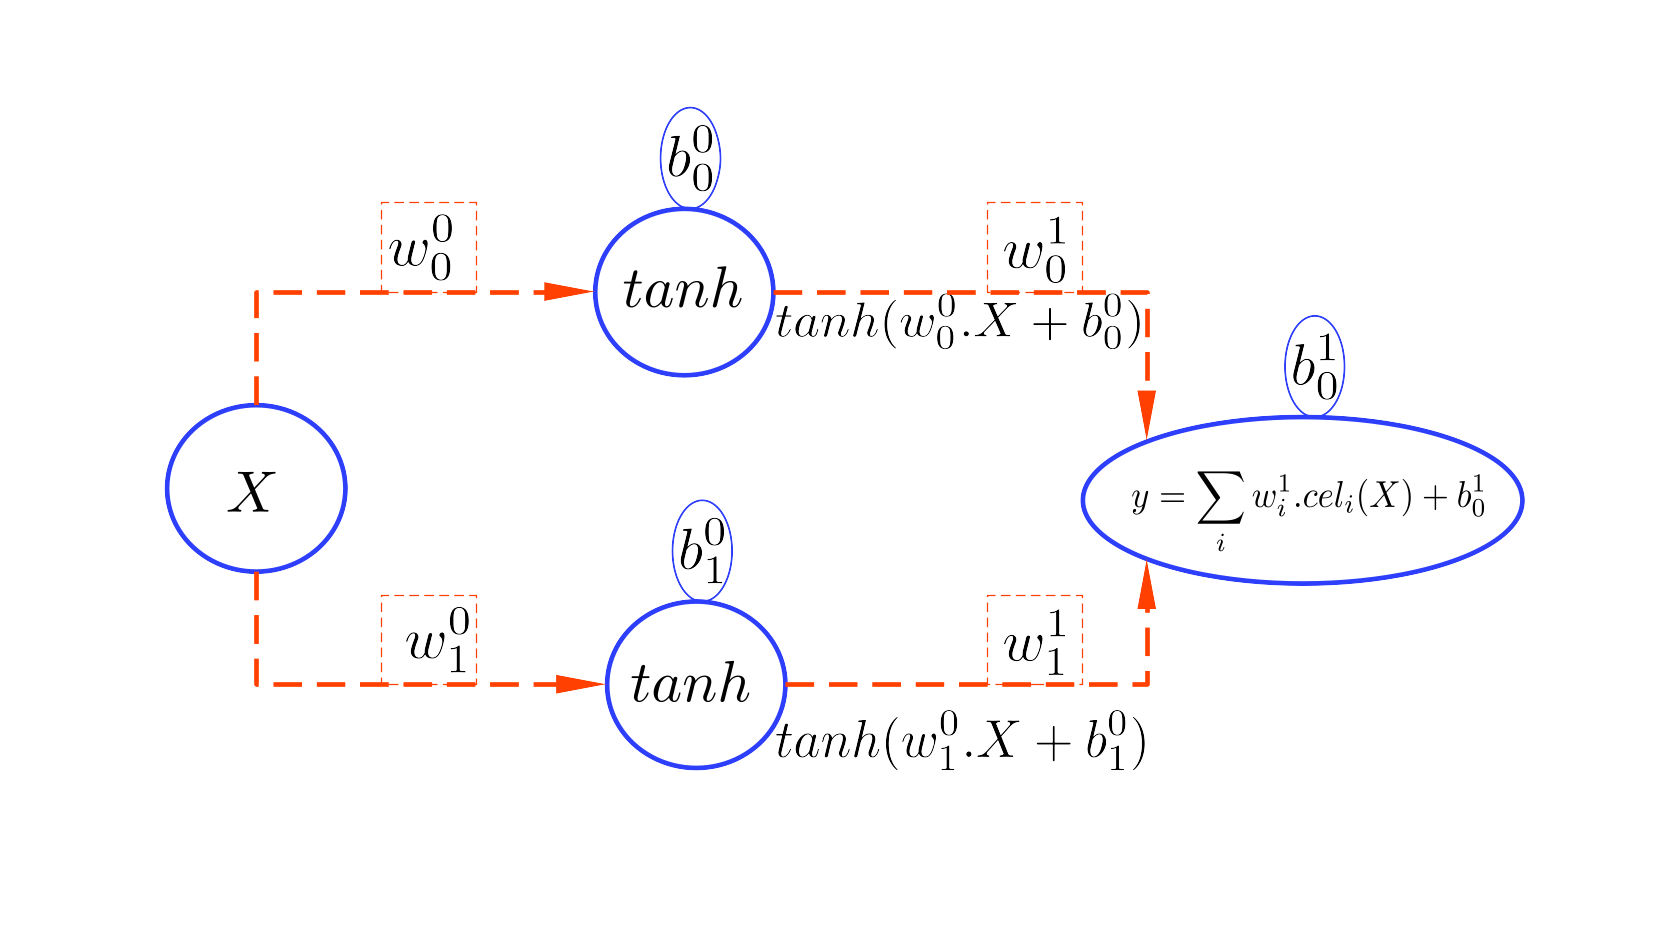

In [11]:
from IPython.display import Image
Image(filename = "ANN_1_2.png", width = 800)

### The action of the neuron network can be explictly computed with the weigths and the biases, a total of 7 parameters.
#### Hidden layer:
$$
cel_i(X) = tanh (w_i^0 . X + b_i^0)
$$

#### Output:
$$
y(X) = \sum_i w_i^1 . cel_i(X) + b_0^1 \\
= w_0^1 . tanh (w_0^0 . X + b_0^0) + w_1^1 . tanh (w_1^0 . X + b_1^0) + b_0^1
$$

### The weights and biases of the individual neurons can be obtained from the scikit object. 
* coefs_ are the weigths of each synapse. It is a 3 dims list: coefs_[i_layer][i_previous_neuron][i_neuron]
* intercepts are the biases of each neuron: intercept_[i_layer][i_neuron]

### The ANN is trained on the training sets. Hyper-parameters can be changed. 

The network is the minimal possible: 1 layer of 2 cells. Each cell is performing an $atanh$ operation.

Scikit-learn Multi layer perceptron is used, see (e.g. for the definition of loss): https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [12]:
ANN = MLPRegressor(random_state=42, hidden_layer_sizes=(2,), 
                   tol=1e-7, max_iter=20000, activation='tanh', 
                   solver='adam', verbose=False)
print(ANN)

MLPRegressor(activation='tanh', hidden_layer_sizes=(2,), max_iter=20000,
             random_state=42, tol=1e-07)


In [13]:
ANN.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (2,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 20000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

The X and y dataset needs to be reformated by adding a dimension

In [14]:
ANN_fit = ANN.fit(X_train2, y_train_true)

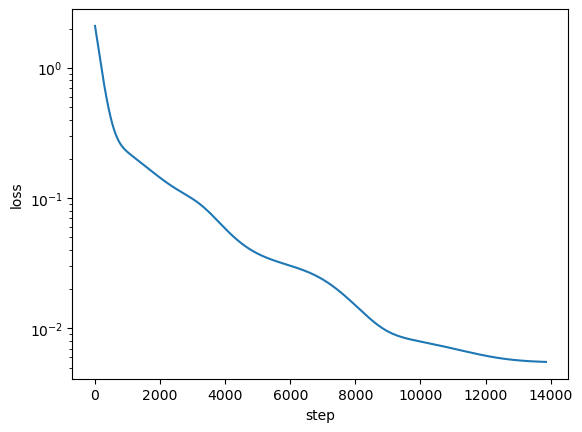

In [15]:
f, ax = plt.subplots()
ax.plot(ANN.loss_curve_)
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_yscale('log');

In [16]:
y_train = ANN.predict(X_train2)
y_test = ANN.predict(X_test2)
rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

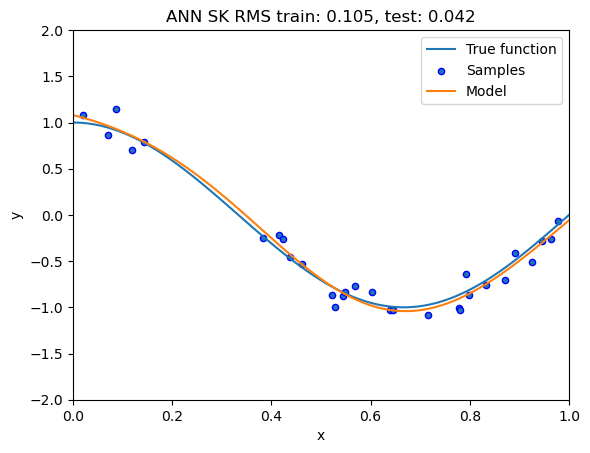

In [17]:
f, ax = plt.subplots()
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
ax.plot(X_test, y_test, label="Model")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("ANN SK RMS train: {:.3f}, test: {:.3f}".format(rms_train, rms_test));

### Access the values of the parameters: weights and bias

In [18]:
print(ANN.coefs_)
print(ANN.intercepts_)

[array([[-1.9481186 ,  2.83121579]]), array([[-3.1975726 ],
       [-2.80249359]])]
[array([ 1.68058519, -1.26361714]), array([1.67584574])]


### The explicit form of the ANN is computed

In [19]:
activation = lambda x: np.tanh(x)
cel_0 = lambda x: activation(x * ANN.coefs_[0][0][0] +ANN.intercepts_[0][0])
cel_1 = lambda x: activation(x *ANN.coefs_[0][0][1] +ANN.intercepts_[0][1])
output = lambda x: cel_0(x) *ANN.coefs_[1][0][0] + cel_1(x) *ANN.coefs_[1][1][0] +ANN.intercepts_[1][0]

### A plot is done to show the original function, the training sample, the ANN regression and the explicit ANN.

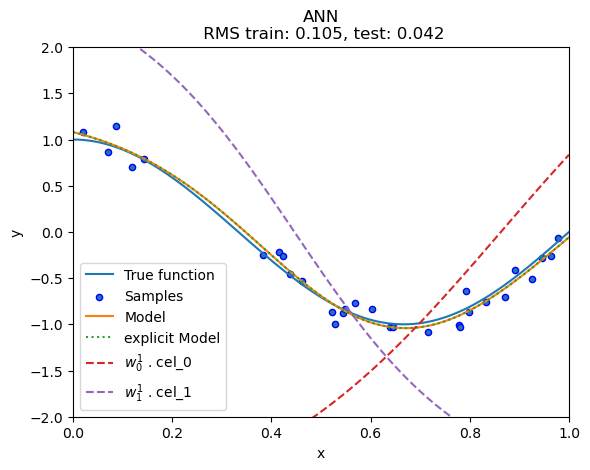

In [20]:
f, ax = plt.subplots()
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
ax.plot(X_test, y_test, label="Model")
ax.plot(X_test, output(X_test), label="explicit Model", ls=':')
ax.plot(X_test, cel_0(X_test)* ANN.coefs_[1][0][0], label=r"$w_0^1$ . cel_0", ls='--')
ax.plot(X_test, cel_1(X_test)* ANN.coefs_[1][1][0], label=r"$w_1^1$ . cel_1", ls='--')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("ANN\n RMS train: {:.3f}, test: {:.3f}".format(
             rms_train, rms_test));

## Using Tensorflow

In [21]:
ANN_tf = Sequential()
ANN_tf.add(Input(shape=(1,)))
ANN_tf.add(Dense(2, activation='tanh'))
ANN_tf.add(Dense(1, activation='linear'))
ANN_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
ANN_tf.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
# ANN_tf_fit = ANN_tf.fit(X_train, y_train_true, epochs=15000, verbose=False)
# 3.5 min with keras 3, 15s with tf_keras

# The following is used for TF > 2.16 (Keras = 3.x):
ds = tensorflow.data.Dataset.from_tensor_slices((X_train, y_train_true)).batch(32)
ANN_tf_fit = ANN_tf.fit(ds, epochs=15000, verbose=False)

In [23]:
y_train_tf = ANN_tf.predict(X_train)
y_test_tf = ANN_tf.predict(X_test)
rms_train_tf = np.sqrt(mean_squared_error(y_train_tf,y_train_true))
rms_test_tf = np.sqrt(mean_squared_error(y_test_tf,y_test_true))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


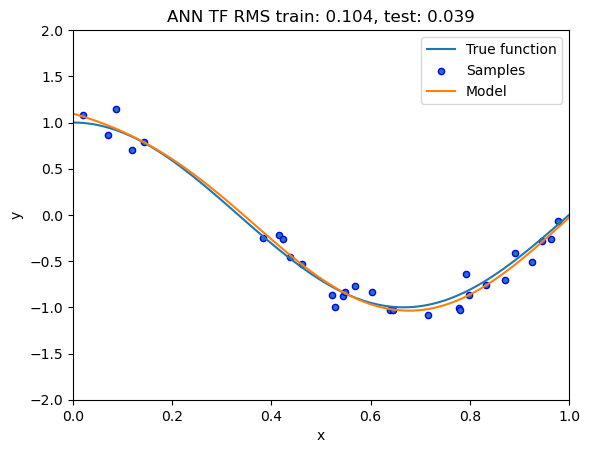

In [24]:
f, ax = plt.subplots()
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
ax.plot(X_test, y_test_tf, label="Model")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("ANN TF RMS train: {:.3f}, test: {:.3f}".format(rms_train_tf, rms_test_tf));

***
## A comparison is made between 3 polynomial fits and 3 ANN computations (using RELU activation functions).

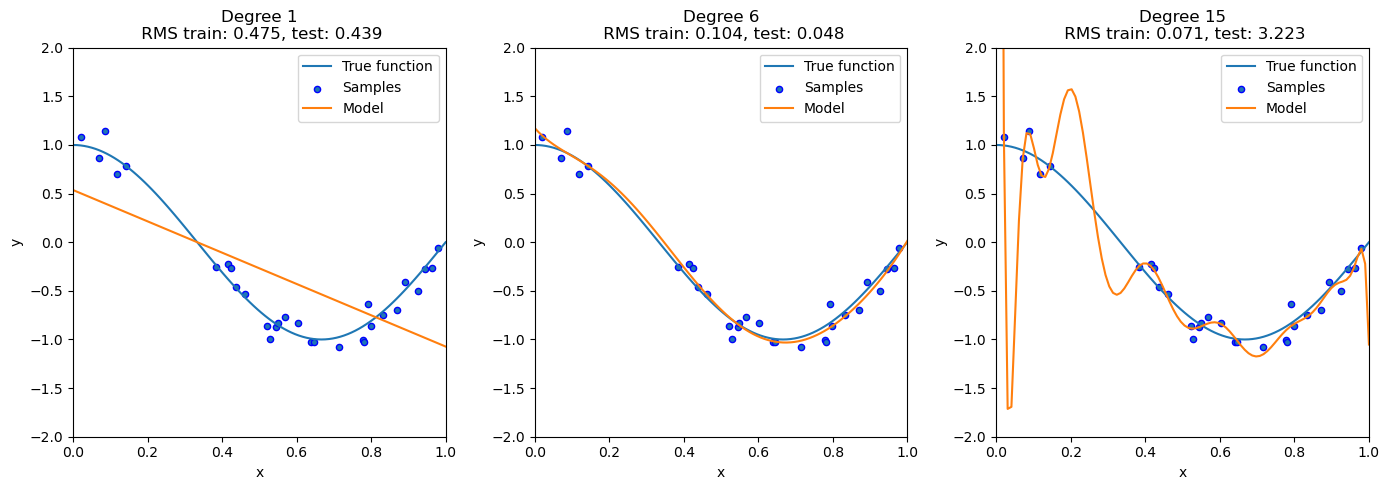

In [25]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))

degrees = [1, 6, 15]
for i, degree in enumerate(degrees):
    ax = axes[i]

    z_np = np.polyfit(X_train, y_train_true, degree)
    p_np = np.poly1d(z_np)

    y_train_np = p_np(X_train)
    rms_train_np = np.sqrt(mean_squared_error(y_train_np,y_train_true))

    y_test_np = p_np(X_test)
    rms_test_np = np.sqrt(mean_squared_error(y_test_np,y_test_true))

    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
    ax.plot(X_test, y_test_np, label="Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}".format(degree,
                rms_train_np, rms_test_np));
f.tight_layout()


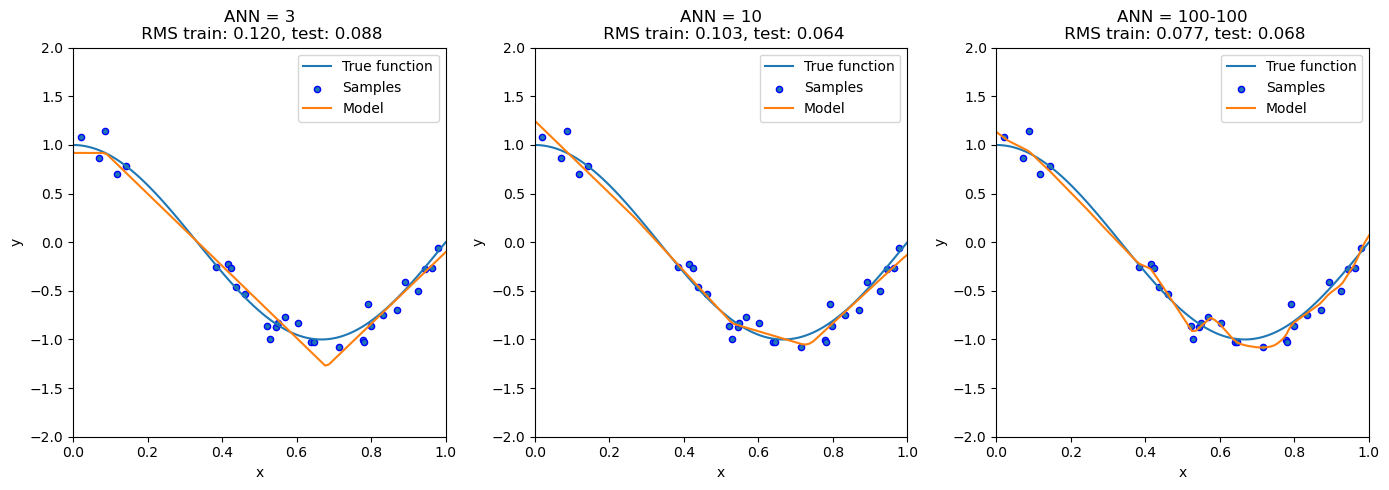

In [26]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))

scaler = StandardScaler()
scaler.fit(X_train2)
transform = scaler.transform
#transform = lambda x:x
hidden_layer_sizes_set = ( (3,), (10,), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):

    ax = axes[i]

    ANN = MLPRegressor(random_state=42, hidden_layer_sizes=hidden_layer_sizes_set[i], 
                       tol=1e-6, max_iter=10000, activation='relu',  # activations: 'tanh', 'relu', 'logistic'
                       solver='adam', verbose=False) # solver: 'adam', 'lbfgs','sgd
    
    ANN_fit = ANN.fit(transform(X_train2), y_train_true)

    y_train = ANN.predict(transform(X_train2))
    y_test = ANN.predict(transform(X_test2))
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
    ax.plot(X_test, y_test, label="Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"ANN = {hidden_layer_sizes_strs[i]}\n RMS train: {rms_train:.3f}, test: {rms_test:.3f}")
f.tight_layout()

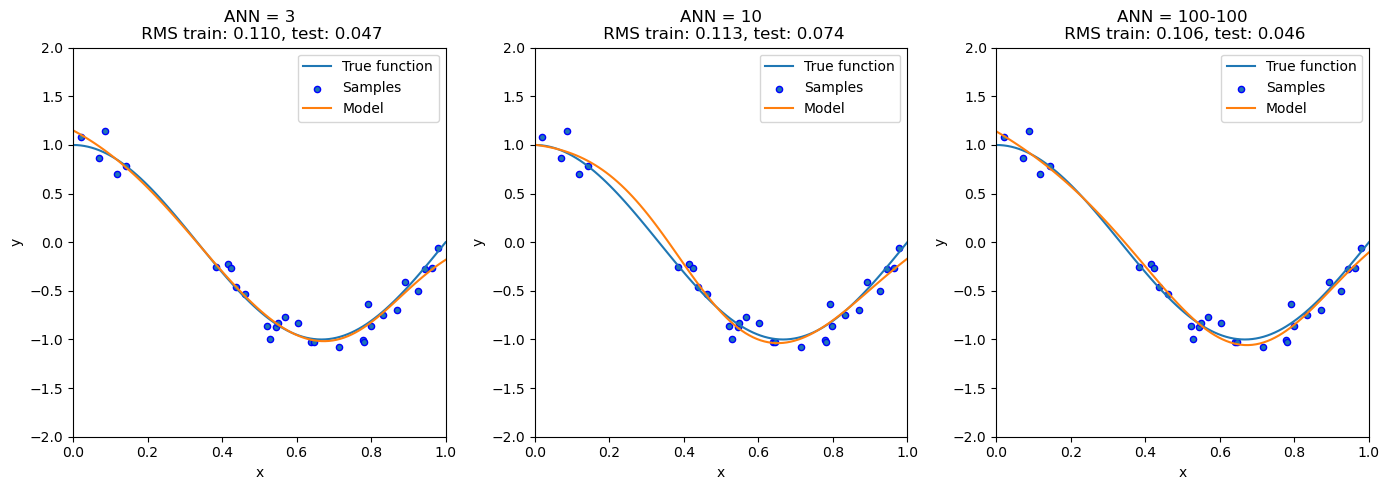

In [27]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))

scaler = StandardScaler()
scaler.fit(X_train2)
transform = scaler.transform
#transform = lambda x:x
hidden_layer_sizes_set = ( (3,), (10,), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):

    ax = axes[i]

    ANN = MLPRegressor(random_state=42, hidden_layer_sizes=hidden_layer_sizes_set[i], 
                       tol=1e-6, max_iter=10000, activation='tanh',  # activations: 'tanh', 'relu', 'logistic'
                       solver='adam', verbose=False) # solver: 'adam', 'lbfgs','sgd
    
    ANN_fit = ANN.fit(transform(X_train2), y_train_true)

    y_train = ANN.predict(transform(X_train2))
    y_test = ANN.predict(transform(X_test2))
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
    ax.plot(X_test, y_test, label="Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"ANN = {hidden_layer_sizes_strs[i]}\n RMS train: {rms_train:.3f}, test: {rms_test:.3f}")
f.tight_layout()

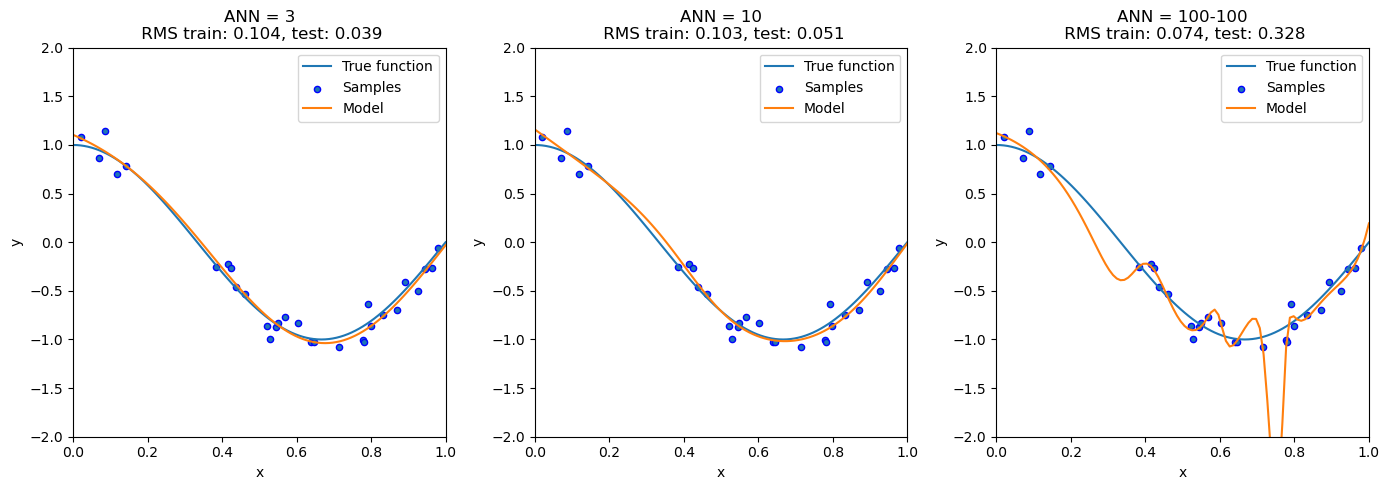

In [28]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))

scaler = StandardScaler()
scaler.fit(X_train2)
transform = scaler.transform
#transform = lambda x:x
hidden_layer_sizes_set = ( (3,), (10,), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):

    ax = axes[i]

    ANN = MLPRegressor(random_state=45, hidden_layer_sizes=hidden_layer_sizes_set[i], 
                       tol=1e-6, max_iter=10000, activation='tanh',  # activations: 'tanh', 'relu', 'logistic'
                       solver='lbfgs', verbose=False) # solver: 'adam', 'lbfgs','sgd
    
    ANN_fit = ANN.fit(transform(X_train2), y_train_true)

    y_train = ANN.predict(transform(X_train2))
    y_test = ANN.predict(transform(X_test2))
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
    ax.plot(X_test, y_test, label="Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"ANN = {hidden_layer_sizes_strs[i]}\n RMS train: {rms_train:.3f}, test: {rms_test:.3f}")
f.tight_layout()

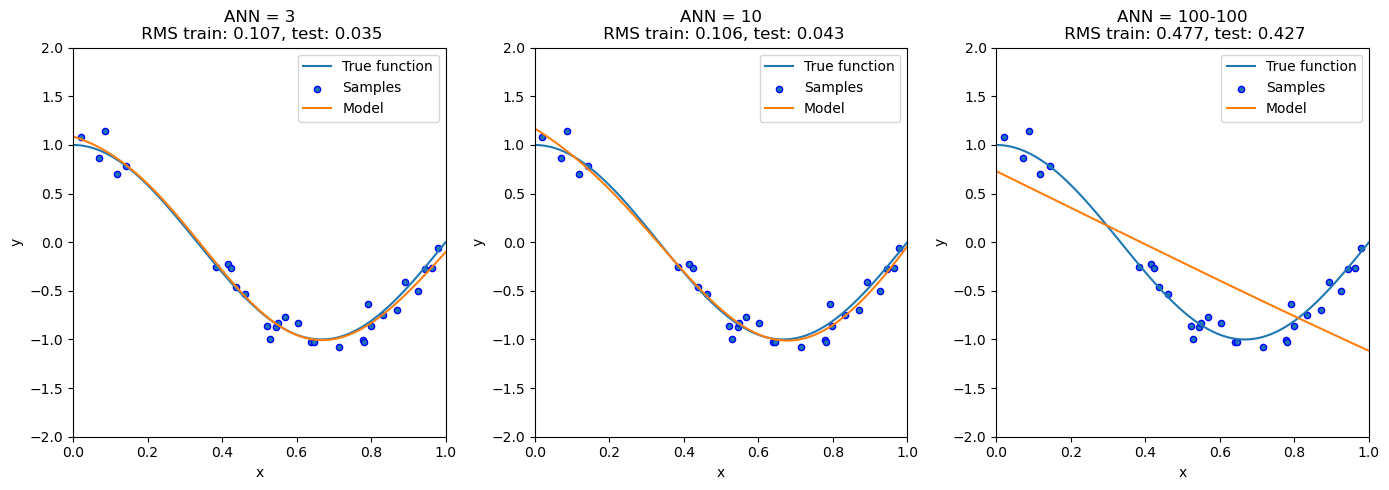

In [29]:
f, axes = plt.subplots(1, 3, figsize=(14, 5))

scaler = StandardScaler()
scaler.fit(X_train2)
transform = scaler.transform
transform = lambda x:x
hidden_layer_sizes_set = ( (3,), (10,), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):

    ax = axes[i]

    ANN = MLPRegressor(random_state=42, hidden_layer_sizes=hidden_layer_sizes_set[i], 
                       tol=1e-6, max_iter=10000, activation='tanh',  # activations: 'tanh', 'relu', 'logistic'
                       solver='adam', verbose=False) # solver: 'adam', 'lbfgs','sgd
    
    ANN_fit = ANN.fit(transform(X_train2), y_train_true)

    y_train = ANN.predict(transform(X_train2))
    y_test = ANN.predict(transform(X_test2))
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

    ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X_train, y_train_true, edgecolor='b', s=20, label="Samples")
    ax.plot(X_test, y_test, label="Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"ANN = {hidden_layer_sizes_strs[i]}\n RMS train: {rms_train:.3f}, test: {rms_test:.3f}")
f.tight_layout()